In [798]:
import pandas as pd
import pickle
from pathlib import Path
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import networkx as nx
from scipy import sparse
import numpy as np
import random

In [807]:
filenames = []
prop_files = []
for filename in Path('digg-exog-by-inf-sim2020-01-14T00-04-03.339633/').rglob('*.pickle'):
    filenames.append(filename)
for filename in Path('digg-exog-by-inf-sim2020-01-14T00-04-03.339633/').rglob('Propagations0.txt'):
    prop_files.append(filename)

/home/fcinus/miniconda3/envs/womgana/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


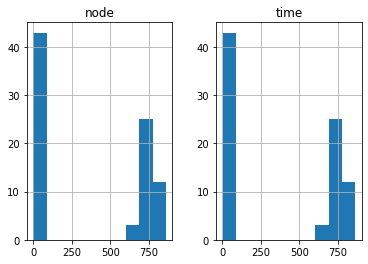

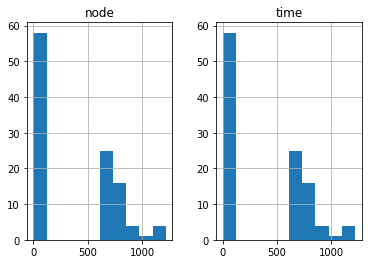

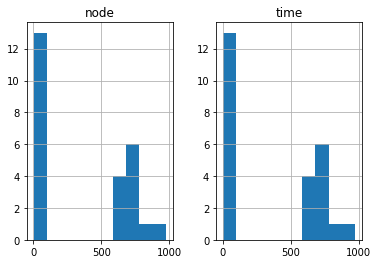

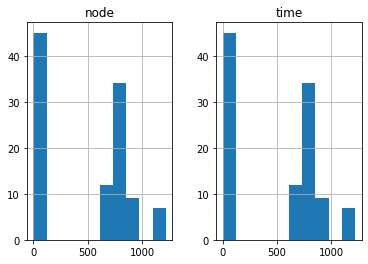

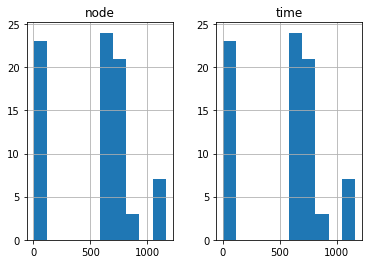

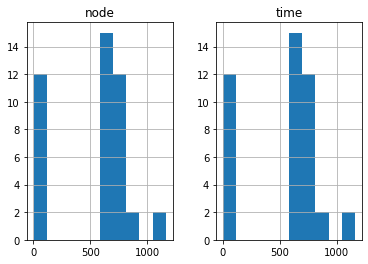

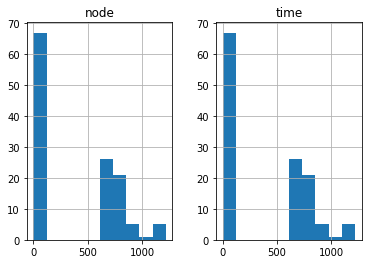

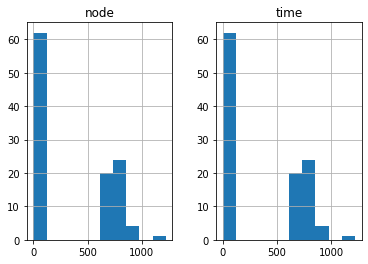

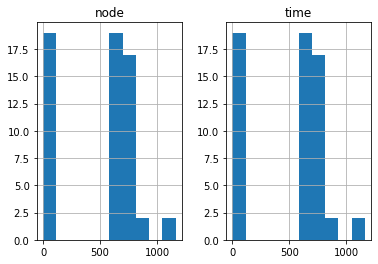

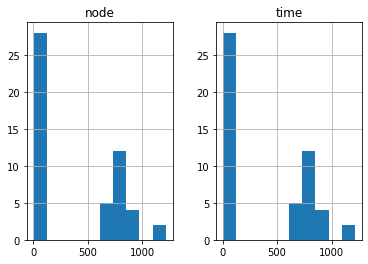

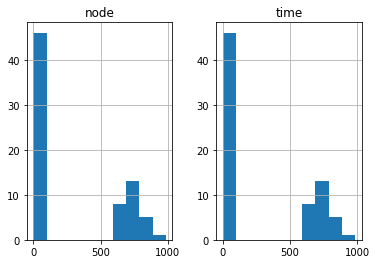

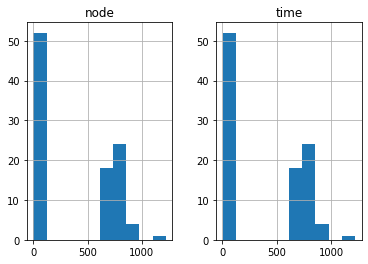

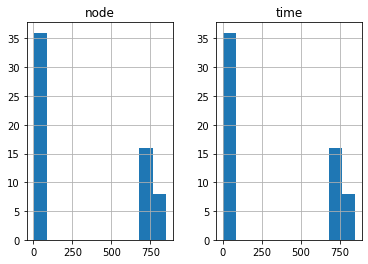

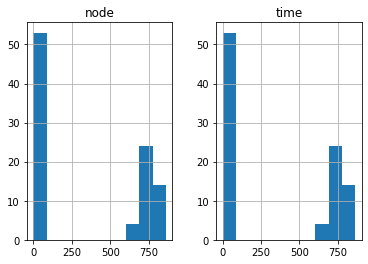

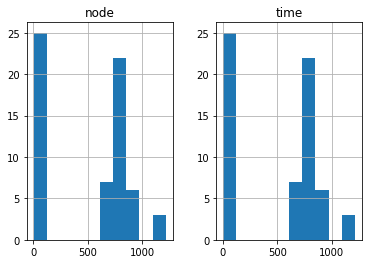

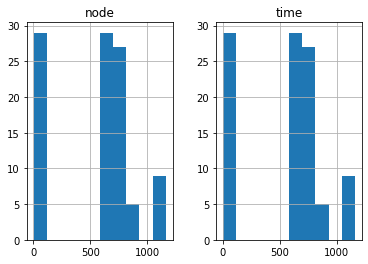

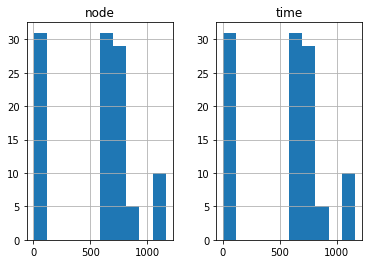

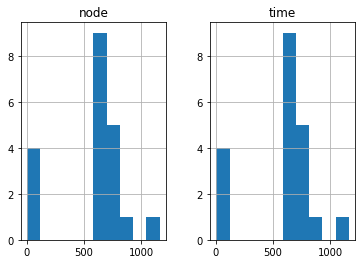

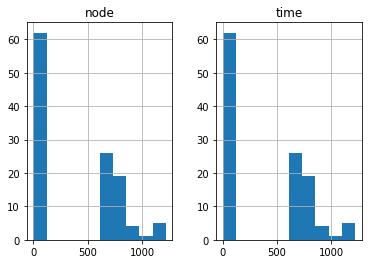

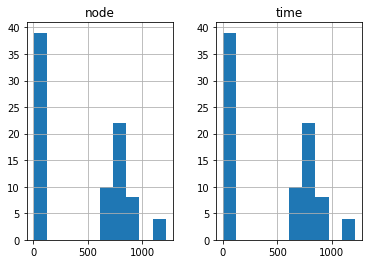

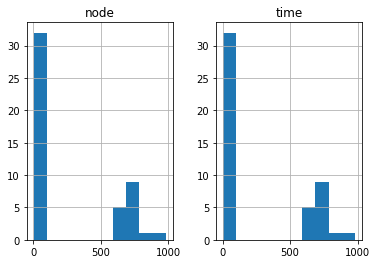

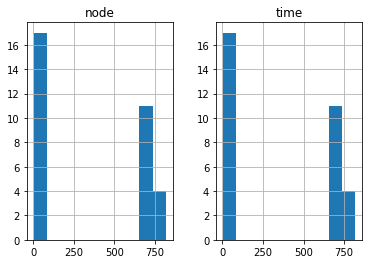

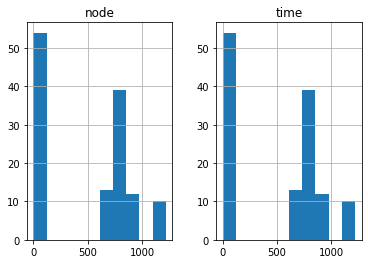

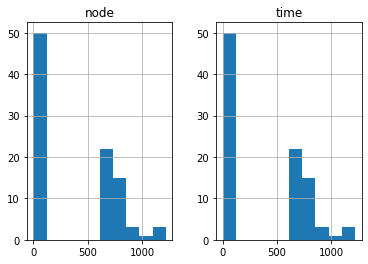

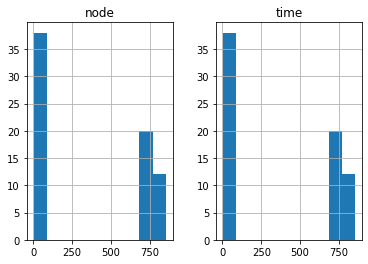

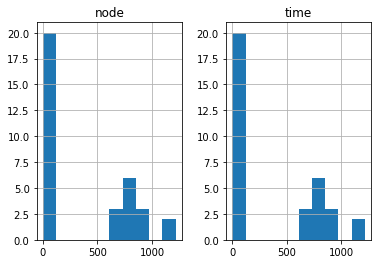

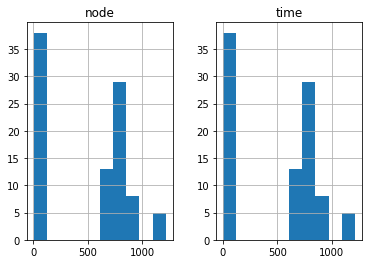

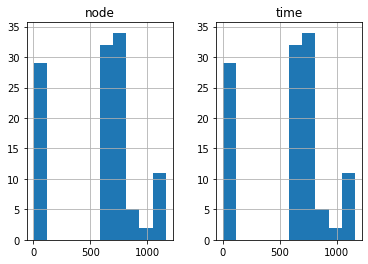

In [804]:
for filename in prop_files:
    df = pd.read_csv(filename, sep=' ', names=['time', 'item', 'node'])
    df.groupby('item').count().hist()

digg-exog-by-inf-sim2020-01-14T00-04-03.339633/6539c62b-8116-4420-b2fb-179475d38894/threshold_values.pickle


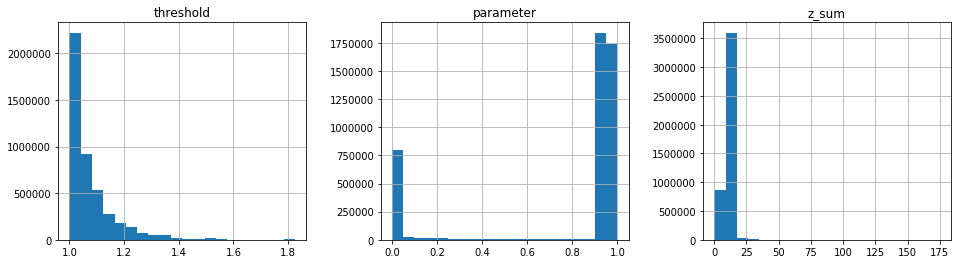

4510112


In [809]:
for filename in filenames:
    with open(filename, 'rb') as f:
        l = pickle.load(f)
    if len(l)!=0:
        print(filename)
        df = pd.DataFrame(l, columns=['z_sum', 'threshold'])
        df['parameter'] = df['z_sum'].apply(lambda x: 1/(1+np.exp(-x+10)))
        fig, ax = plt.subplots(1,3, figsize=(16, 4))
        
        df.hist('threshold', ax=ax[0], bins=20)
        df.hist('parameter', ax=ax[1], bins=20)
        df.hist('z_sum', ax=ax[2], bins=20)#np.arange(0, 100, 1))
        #ax[2].set_xlim((0,50))
        plt.show()
        print(len(df['z_sum']))
        break

In [810]:
topics = 10
docs = 1000
H = .5
nodes_numb = 1000
G = nx.scale_free_graph(nodes_numb)
seed = 4
virality_exp = 10
gn_strh = 2.5

In [811]:
# functions
f = lambda x: 1/(1+np.exp(-x+10))
f2 = lambda x: x/(x+1)
f3 = lambda x: np.log(x+1)/(np.log(x+1)+1)
print(f(10), f2(10), f3(10))

0.5 0.9090909090909091 0.7057001703361976


19.96137600431701


(array([645., 223.,  73.,  32.,  12.,   7.,   3.,   1.,   2.,   2.]),
 array([18.00602634, 19.93753974, 21.86905314, 23.80056655, 25.73207995,
        27.66359335, 29.59510675, 31.52662016, 33.45813356, 35.38964696,
        37.32116036]),
 <a list of 10 Patch objects>)

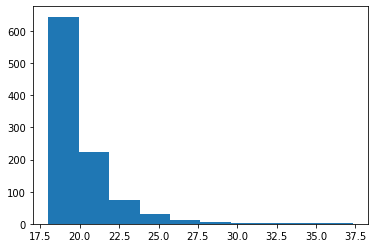

In [812]:
# thresholds
vec_thr = [18*(1+np.random.pareto(virality_exp)) for _ in range(docs)]
print(np.mean(vec_thr))
plt.hist(vec_thr,)

In [720]:
# items description
alpha =  [1. / topics for i in range(topics)]
gammas = {}
for item in range(docs):
    gammas[item] = np.random.dirichlet(alpha)
df_gammas = pd.DataFrame(gammas)

In [695]:
# interests
from sklearn.decomposition import NMF
def nmf_emb(G, dimensions, seed, H):
    A = nx.adjacency_matrix(G)
    S_0 = overlap_generator(A)
    R = np.random.rand(G.number_of_nodes(), G.number_of_nodes())
    #S = beta*(S_0 + A + sparse.identity(A.shape[0])) + (1-beta)*R
    eta = 64.
    beta = 16 - 15.875*H
    S = eta*S_0 + A + beta*R
    model = NMF(n_components=dimensions, init='nndsvd', random_state=seed)
    W = model.fit_transform(S)
    return W
def overlap_generator(A):
    """
    Generate the second order overlap from a sparse adjacency matrix A.
    """
    aat = A.dot(A.T)
    d = aat.diagonal()
    ndiag = sparse.diags(d, 0)
    n = np.sqrt(ndiag.dot(aat>0).dot(ndiag))
    n.data[:] = 1./n.data[:]
    return aat.multiply(n) #- sparse.identity(aat.shape[0])

1000


(array([ 27.,  86.,  81.,  43.,  23.,   8.,  12.,   9.,   7.,   1.,  10.,
          5.,   6.,  10.,  18.,  17.,  14.,  54., 161.,  41.,  72., 140.,
         29.,  30.,  38.,  21.,  16.,  10.,   6.,   5.]),
 array([0.72021089, 0.72274635, 0.7252818 , 0.72781726, 0.73035272,
        0.73288818, 0.73542364, 0.73795909, 0.74049455, 0.74303001,
        0.74556547, 0.74810092, 0.75063638, 0.75317184, 0.7557073 ,
        0.75824276, 0.76077821, 0.76331367, 0.76584913, 0.76838459,
        0.77092004, 0.7734555 , 0.77599096, 0.77852642, 0.78106187,
        0.78359733, 0.78613279, 0.78866825, 0.79120371, 0.79373916,
        0.79627462]),
 <a list of 30 Patch objects>)

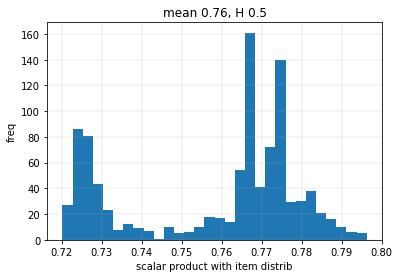

In [696]:
W = nmf_emb(G, topics, seed, H)
weights = []
for node in G.nodes:
    #weight = f3(np.dot(W[node]/np.linalg.norm(W[node]), gammas[0]+gn_strh*(np.ones(topics))))
    weight = f3(np.dot(W[node], gammas[0]+gn_strh*(np.ones(topics))))
    weights.append(weight)

fig, ax = plt.subplots(1)
print(len(weights))
ax.set_title('mean '+str(round(np.mean(weights),2))+ ', H '+str(H))
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 250)
ax.set_xlabel('scalar product with item distrib')
ax.set_ylabel('freq')
ax.grid(linestyle='-', linewidth=0.2)
ax.hist(weights, bins=30) 

,0,1,2,3,4,5,6,7,8,9
0,3.896945,4.284939,4.034491,1.817821,0.000000,0.162705,2.035504,2.501483,0.000000,0.147069
1,0.193837,5.156767,0.086853,0.112982,5.328751,0.234839,0.200777,0.425867,0.714594,0.404008
2,7.356966,0.885842,0.883275,0.162364,1.056029,0.228752,0.317073,1.134104,0.429863,0.392013
3,5.747361,4.810199,2.307528,0.718126,1.438086,0.463024,0.554157,0.425737,0.311776,0.554835
4,7.283270,0.120547,0.147685,0.219631,1.919024,0.143159,0.118450,0.274702,0.661980,0.509956


(array([4., 0., 0., 0., 2., 1., 0., 0., 0., 3.]),
 array([0.        , 0.42849387, 0.85698773, 1.2854816 , 1.71397547,
        2.14246934, 2.5709632 , 2.99945707, 3.42795094, 3.85644481,
        4.28493867]),
 <a list of 10 Patch objects>)

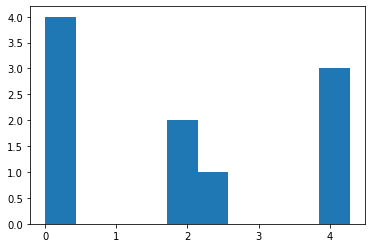

In [697]:
df_interests = pd.DataFrame(W)
display(df_interests.head())
plt.hist(df_interests.iloc[0])

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.322340e-05,3.576061e-14,5.081711e-03,1.623163e-03,0.000017,0.006950,0.021990,0.005795,0.595489,1.038200e-08,...,9.357276e-26,6.667580e-06,4.393481e-10,4.072182e-11,1.024176e-05,3.237448e-07,1.328846e-03,0.029735,9.511918e-01,0.557156
1,2.744168e-04,1.513448e-05,8.042499e-13,8.049004e-01,0.000014,0.006321,0.000223,0.007356,0.011456,3.865216e-13,...,3.164040e-01,4.346853e-09,5.997110e-03,2.277426e-20,2.699514e-01,1.415798e-06,1.708657e-12,0.000131,1.461407e-03,0.000007
2,1.922764e-07,8.350216e-03,2.594130e-02,4.743378e-05,0.972671,0.059551,0.011889,0.004079,0.000034,2.739232e-08,...,4.819415e-01,5.025214e-08,3.551212e-07,7.746701e-01,1.255579e-05,4.946355e-04,2.560829e-04,0.000021,1.612170e-07,0.000770
3,5.568897e-06,1.117011e-02,6.832428e-12,6.542094e-04,0.000005,0.115645,0.125104,0.400823,0.303281,1.917389e-04,...,2.127181e-06,8.400227e-04,1.949529e-02,1.917205e-05,1.730751e-13,6.142608e-01,2.029223e-02,0.830407,1.111029e-06,0.001871
4,1.009707e-05,1.473768e-07,5.913289e-03,5.811474e-07,0.000055,0.000080,0.002606,0.004293,0.084379,8.632937e-01,...,1.244232e-02,4.713474e-01,1.417708e-04,2.916602e-02,1.756220e-01,6.551115e-04,7.456331e-04,0.000902,1.649534e-08,0.000124


(array([782.,  45.,  39.,  24.,  25.,  22.,  17.,  10.,  23.,  13.]),
 array([3.84420684e-30, 9.99761092e-02, 1.99952218e-01, 2.99928328e-01,
        3.99904437e-01, 4.99880546e-01, 5.99856655e-01, 6.99832764e-01,
        7.99808874e-01, 8.99784983e-01, 9.99761092e-01]),
 <a list of 10 Patch objects>)

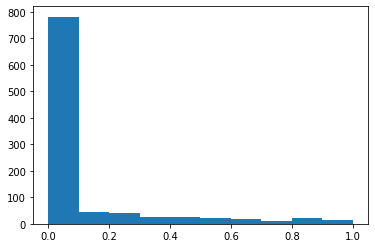

In [698]:
display(df_gammas.head())
plt.hist(df_gammas.iloc[0])

first node dot product: 0.023313989063726073  value of f: 0.02252719939492674  mean: 0.6011904236236753


Text(0.5, 0, 'function of dot products - item distr times int + gn')

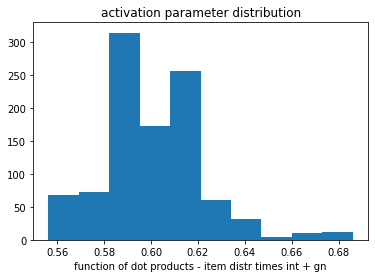

In [699]:
#x = np.dot(gammas[0], W[0]+gn_strh*(np.ones(topics)))
x = np.dot(gammas[0], W[0]+gn_strh*(W[0]))
dots = [f3(np.dot(gammas[0], W[i]+gn_strh*(np.ones(topics)))) for i in range(W.shape[0])]
#dots = [f3(np.dot(gammas[0], W[i]+5.*(W[i]))) for i in range(W.shape[0])]
print('first node dot product:', x, ' value of f:', f3(x), ' mean:', np.mean(dots))
plt.hist(dots)
plt.title('activation parameter distribution')
plt.xlabel('function of dot products - item distr times int + gn')

In [700]:
activations = []
for i in range(len(vec_thr)):
    activations.append([dots[j] > vec_thr[i] for j in range(len(dots))])
df_activations = pd.DataFrame(activations)
df_activations.sum()

0      1
1      2
2      2
3      2
4      2
      ..
995    2
996    2
997    2
998    3
999    2
Length: 1000, dtype: int64

In [644]:
g = nx.DiGraph()
g.add_node(1)
nx.dag_longest_path(g)

[1]

In [737]:
1+np.random.pareto(10)

1.0493984964265424